In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
import string
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import joblib


### 1.  load in data and generate some numeric  features

In [2]:
data=pd.read_csv('notdoctornote_4training_0416.csv')
datatest=pd.read_csv('notdoctornote_4testing_0416.csv')

In [3]:
data=pd.concat([data,datatest])  # combine the two

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [4]:
data=data.reset_index(drop=True)

In [5]:
# reshuffle, to make the distribution more evenly
shuffled = data.reindex(np.random.permutation(data.index))

In [6]:
len(shuffled)*0.7

88979.09999999999

In [7]:
# split the training and testing to 70% and 30%
data=shuffled[:88980]
datatest=shuffled[88981+1:]
print(len(data))
print(len(datatest))

88980
38131


In [8]:
data[['chart_id']][data['flag']==0].nunique()

chart_id    1929
dtype: int64

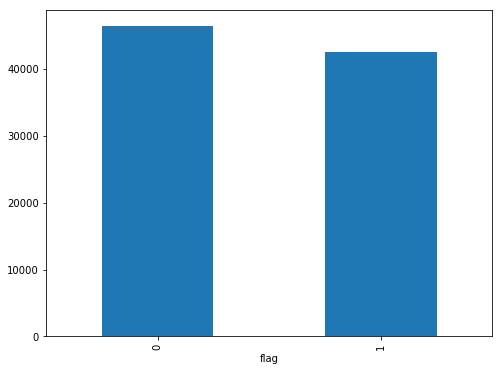

In [9]:
fig = plt.figure(figsize=(8,6))
data.groupby('flag').chart_id.count().plot.bar(ylim=0)
plt.show()

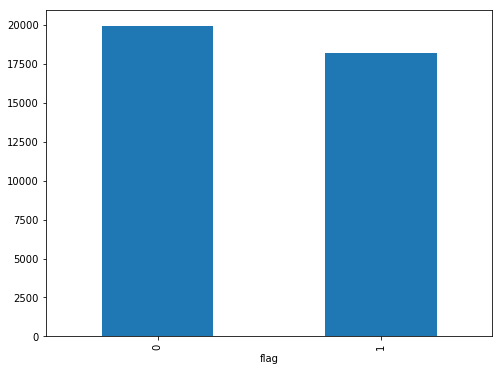

In [10]:
fig = plt.figure(figsize=(8,6))
datatest.groupby('flag').chart_id.count().plot.bar(ylim=0)
plt.show()

In [11]:
len(data[data['flag']==1])

42560

In [12]:
len(data)

88980

In [13]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'chart_id', 'end_offset', 'flag',
       'pagetext', 'start_offset', 'submission_id'],
      dtype='object')

In [14]:
data.drop('Unnamed: 0.1', axis=1, inplace=True)
datatest.drop('Unnamed: 0.1', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
data=data.reset_index(drop=True)
datatest=datatest.reset_index(drop=True)

In [16]:
data.head()

,Unnamed: 0,chart_id,end_offset,flag,pagetext,start_offset,submission_id
0,7123,IBXRMA2018_MULT_1196571510010002_HMK_200426039...,1917,0,"Patient:RICHARD,SLOUGHDate of Birth: 1/28/...",0,3298be94-7c39-4260-81bc-6d4c51a37aa7
1,9121,IBXRMA2018_MULT_1211361730010001_HMK_174427742...,2762,1,"Keystone Health NetworkJune 29, 2018 100 Wes...",1483,4dcb85f2-c69a-4b24-96fb-8f1e31251a18
2,8248,IBXRMA2018_MULT_1217373580010001_HMK_167349537...,38977,0,Hx of Peripheral Vascular Disease No...,37778,485fdae0-33b4-47d2-be1a-b9e4d7c2936b
3,12722,ibxrma2018_mult_1217545300010001_hmk_175366844...,101683,0,Old myocardial infarction Coronary atherosc...,99184,6257c5f4-1a32-45d5-a9d6-162546c5535a
4,25354,IBXRMA2018_MULT_1218016700010001_HMK_187282047...,82563,0,:21249) Page 1 of 2 Patient Name FISHGOL...,80869,bf770d23-f0fa-4f4e-9b4f-f3adb32a6ce0


In [17]:
datatest.head()

,Unnamed: 0,chart_id,end_offset,flag,pagetext,start_offset,submission_id
0,10818,IBXRMA2018_MULT_1212697540010001_HMK_162585156...,47581,1,t in the wound. You have a fever and your wo...,45189,524e8dd1-6798-4831-bdd2-275e7d604e39
1,18267,IBXRMA2018_MULT_1217558120010001_HMK_177303378...,51819,0,"El Worsened Patient Name-r-16PILL, t Patient...",50560,882ec5ad-7600-492b-8f98-40de885e337a
2,24320,IBXRMA2018_MULT_1216743810010001_HMK_208320024...,23070,0,n: Gateway Internal Medicine West Chester Pa...,22363,c4781bd7-e882-47f8-9911-724924ffc458
3,11124,IBXRMA2018_MULT_1217420990010001_HMK_172260191...,9037,1,"/21/2016 09:54:54 Electr WISNIEWSKI, STANL...",7550,56982040-b7d3-40b6-a2a8-ba7f6656724a
4,21625,IBXRMA2018_MULT_1216757550010001_HMK_175242245...,85838,1,"nt Signed before import by Nicholas Busillo,...",85082,b0a372a3-dc1a-4c84-b1e8-ff0d5b027a5a


In [18]:
data.dtypes

Unnamed: 0        int64
chart_id         object
end_offset        int64
flag              int64
pagetext         object
start_offset      int64
submission_id    object
dtype: object

In [19]:
data['pagetext'] = data['pagetext'].astype('str') 
datatest['pagetext'] = datatest['pagetext'].astype('str') 

In [158]:
def count_string(string):
    count = 0
    for i in at.finditer(string):
        count += 1
    return count

def count_special(string):
    return (len(string) - len(re.sub(r"[~\!@#\$%\^&\*\(\)_\+{}\":;'\[\]]",'', string)))

In [159]:
at = re.compile(r"%", re.I)
data["percent_count"] = data["pagetext"].map(count_string)
at = re.compile(r"-", re.I)
data["hyphen_count"] = data["pagetext"].map(count_string)
at = re.compile(r"/", re.I)
data["forwardslash_count"] = data["pagetext"].map(count_string)
at = re.compile(r">", re.I)
data["greaterthan_count"] = data["pagetext"].map(count_string)
at = re.compile(r"<", re.I)
data["lesserthan_count"] = data["pagetext"].map(count_string)
at = re.compile(r"=", re.I)
data["equalto_count"] = data["pagetext"].map(count_string)
at = re.compile(r":", re.I)
data["colon_count"] = data["pagetext"].map(count_string)
data["specialcharacter_count"] = data["pagetext"].apply(lambda x: count_special(x))
data['char_count'] = data['pagetext'].apply(len)
data['word_count'] = data['pagetext'].apply(lambda x: len(x.split()))
data['word_density'] = data['char_count'] / (data['word_count']+1)
data['punctuation_count'] = data['pagetext'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
data['title_word_count'] = data['pagetext'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
data['upper_case_word_count'] = data['pagetext'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [171]:
at = re.compile(r"%", re.I)
datatest["percent_count"] = datatest["pagetext"].map(count_string)
at = re.compile(r"-", re.I)
datatest["hyphen_count"] = datatest["pagetext"].map(count_string)
at = re.compile(r"/", re.I)
datatest["forwardslash_count"] = datatest["pagetext"].map(count_string)
at = re.compile(r">", re.I)
datatest["greaterthan_count"] = datatest["pagetext"].map(count_string)
at = re.compile(r"<", re.I)
datatest["lesserthan_count"] = datatest["pagetext"].map(count_string)
at = re.compile(r"=", re.I)
datatest["equalto_count"] = datatest["pagetext"].map(count_string)
at = re.compile(r":", re.I)
datatest["colon_count"] = datatest["pagetext"].map(count_string)
datatest["specialcharacter_count"] = datatest["pagetext"].apply(lambda x: count_special(x))
datatest['char_count'] = datatest['pagetext'].apply(len)
datatest['word_count'] = datatest['pagetext'].apply(lambda x: len(x.split()))
datatest['word_density'] = datatest['char_count'] / (datatest['word_count']+1)
datatest['punctuation_count'] = datatest['pagetext'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
datatest['title_word_count'] = datatest['pagetext'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
datatest['upper_case_word_count'] = datatest['pagetext'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

### 2. Feature correlation and some exploratory study

In [172]:
data.columns

Index(['Unnamed: 0.1', 'submission_id', 'chart_id', 'start_offset',
       'end_offset', 'pagetext', 'flag', 'percent_count', 'hyphen_count',
       'forwardslash_count', 'greaterthan_count', 'lesserthan_count',
       'equalto_count', 'colon_count', 'specialcharacter_count', 'char_count',
       'word_count', 'word_density', 'punctuation_count', 'title_word_count',
       'upper_case_word_count'],
      dtype='object')

Data shape
(88980, 21)
Data Features shape 
(88980, 10)


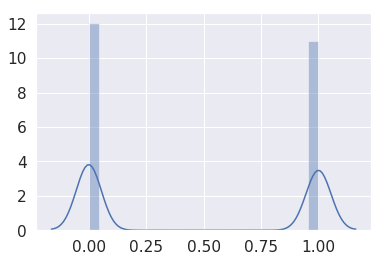

In [240]:
# 0 : agreed charts, 1 : deleted, not-doctor-note

#data_features = data[['percent_count', 'hyphen_count', 'forwardslash_count',
#       'greaterthan_count', 'lesserthan_count', 'equalto_count', 'colon_count',
#       'specialcharacter_count', 'char_count', 'word_count', 'word_density',
#       'punctuation_count', 'title_word_count', 'upper_case_word_count']]
data_features = data[['hyphen_count', 'forwardslash_count','equalto_count', 'colon_count',
       'specialcharacter_count', 'word_count', 'word_density',
       'punctuation_count', 'title_word_count', 'upper_case_word_count']]
#feat importance = [0.01045122 0.03029887 0.03902959 0.00670654 0.00365505 0.01035593
# 0.04210505 0.04324441 0.05750869 0.03884818 0.06019741 0.0469223
# 0.04990416 0.04669896]
data_target = data[['flag']]
print('Data shape')
print(data.shape)
print('Data Features shape ')
print(data_features.shape)
data_features.head()
sns.distplot(data_target);

In [246]:
#datatest_features = datatest[['percent_count', 'hyphen_count', 'forwardslash_count',
#       'greaterthan_count', 'lesserthan_count', 'equalto_count', 'colon_count',
#       'specialcharacter_count', 'char_count', 'word_count', 'word_density',
#       'punctuation_count', 'title_word_count', 'upper_case_word_count']]
datatest_features = datatest[['hyphen_count', 'forwardslash_count','equalto_count', 'colon_count',
       'specialcharacter_count', 'word_count', 'word_density',
       'punctuation_count', 'title_word_count', 'upper_case_word_count']]
#feat importance = [0.01045122 0.03029887 0.03902959 0.00670654 0.0036550
datatest_target = datatest[['flag']]

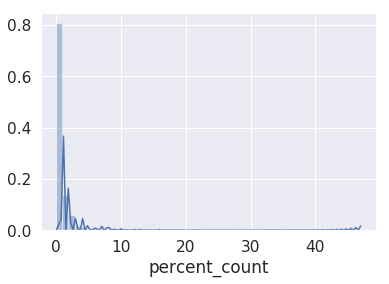

In [174]:
sns.distplot(data['percent_count']);

In [175]:
data.isnull().sum()   # non NaN values

Unnamed: 0.1              0
submission_id             0
chart_id                  0
start_offset              0
end_offset                0
pagetext                  0
flag                      0
percent_count             0
hyphen_count              0
forwardslash_count        0
greaterthan_count         0
lesserthan_count          0
equalto_count             0
colon_count               0
specialcharacter_count    0
char_count                0
word_count                0
word_density              0
punctuation_count         0
title_word_count          0
upper_case_word_count     0
dtype: int64

In [242]:
data.nunique()

Unnamed: 0.1              29461
char_count                 4759
chart_id                   3830
colon_count                 207
end_offset                60468
equalto_count                77
flag                          2
forwardslash_count          201
greaterthan_count            35
hyphen_count                215
lesserthan_count             29
pagetext                  87020
percent_count                39
punctuation_count           673
specialcharacter_count      345
start_offset              59072
submission_id              3894
title_word_count            359
upper_case_word_count       361
word_count                  898
word_density              50601
dtype: int64

flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: percent_count, dtype: object

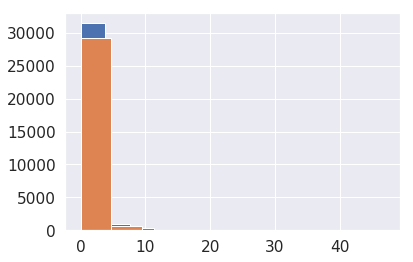

In [177]:
data.groupby('flag').percent_count.hist()

flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hyphen_count, dtype: object

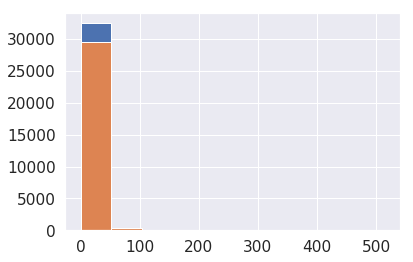

In [178]:
data.groupby('flag').hyphen_count.hist()

flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: greaterthan_count, dtype: object

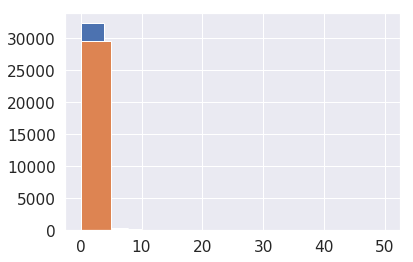

In [179]:
data.groupby('flag').greaterthan_count.hist()

flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: forwardslash_count, dtype: object

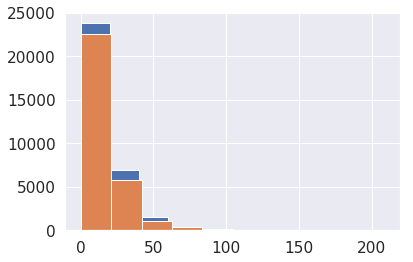

In [180]:
data.groupby('flag').forwardslash_count.hist()

flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: specialcharacter_count, dtype: object

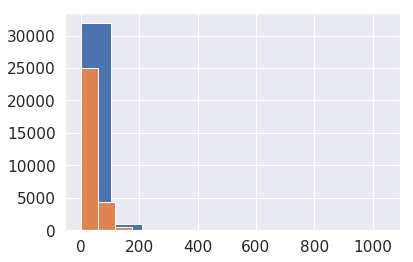

In [181]:
data.groupby('flag').specialcharacter_count.hist()

flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: colon_count, dtype: object

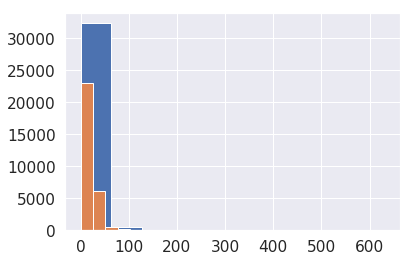

In [182]:
data.groupby('flag').colon_count.hist()

flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: equalto_count, dtype: object

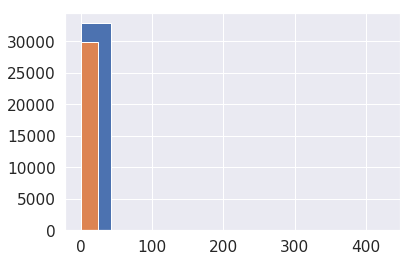

In [183]:
data.groupby('flag').equalto_count.hist()

flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: specialcharacter_count, dtype: object

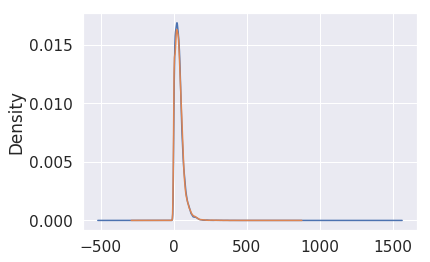

In [184]:
data.groupby('flag').specialcharacter_count.plot(kind='kde')

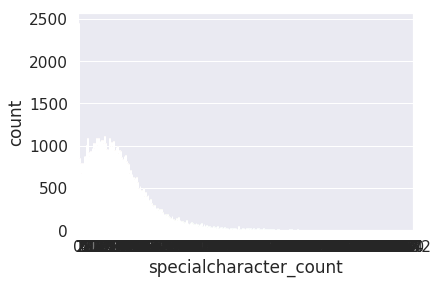

In [185]:
sns.countplot(x='specialcharacter_count',data=data)

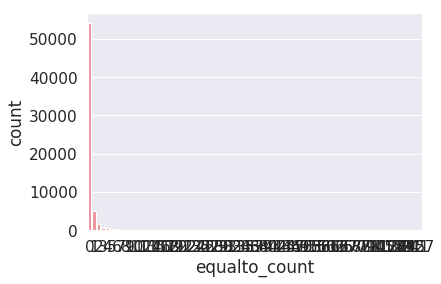

In [186]:
sns.countplot(x='equalto_count',data=data)

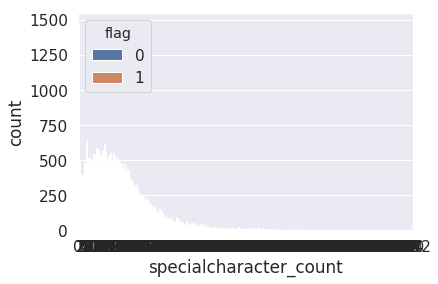

In [187]:
sns.countplot(x='specialcharacter_count',hue='flag',data=data)

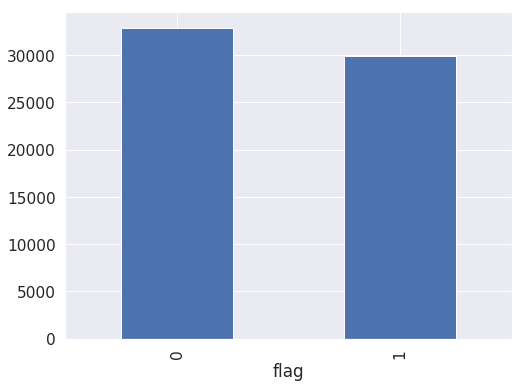

In [188]:
fig = plt.figure(figsize=(8,6))
data.groupby('flag').chart_id.count().plot.bar(ylim=0)
plt.show()

In [ ]:
#clf = svm.SVC(gamma=0.001, C=100.)

In [ ]:
#clf.fit(data_trainf, data_targettrain)  
#SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
#  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
#  max_iter=-1, probability=False, random_state=None, shrinking=True,
#  tol=0.001, verbose=False)

In [ ]:
 #clf.predict(data_testf[-1:])

In [243]:
print(data_features.describe())

       hyphen_count  forwardslash_count  equalto_count   colon_count  \
count  88980.000000        88980.000000   88980.000000  88980.000000   
mean      10.451337           16.130704       0.435862     17.456136   
std       14.555538           18.469878       3.085164     17.395291   
min        0.000000            0.000000       0.000000      0.000000   
25%        2.000000            5.000000       0.000000      6.000000   
50%        7.000000           12.000000       0.000000     14.000000   
75%       14.000000           21.000000       0.000000     24.000000   
max      938.000000          282.000000     382.000000    943.000000   

       specialcharacter_count    word_count  word_density  punctuation_count  \
count            88980.000000  88980.000000  88980.000000       88980.000000   
mean                36.536446    210.932344      7.551338          97.711800   
std                 32.678148    130.839761      1.854132          79.852171   
min                  0.000000  

In [190]:
corr=abs(data_features.corr())
print(corr)

                        percent_count  hyphen_count  forwardslash_count  \
percent_count                1.000000      0.154683            0.161222   
hyphen_count                 0.154683      1.000000            0.204063   
forwardslash_count           0.161222      0.204063            1.000000   
greaterthan_count            0.175866      0.266988            0.178678   
lesserthan_count             0.127345      0.199239            0.070737   
equalto_count                0.064741      0.225580            0.019752   
colon_count                  0.042910      0.283977            0.365236   
specialcharacter_count       0.208583      0.467713            0.393643   
char_count                   0.178460      0.412192            0.464763   
word_count                   0.167723      0.380370            0.365368   
word_density                 0.017735      0.070692            0.192806   
punctuation_count            0.249894      0.658473            0.517833   
title_word_count         

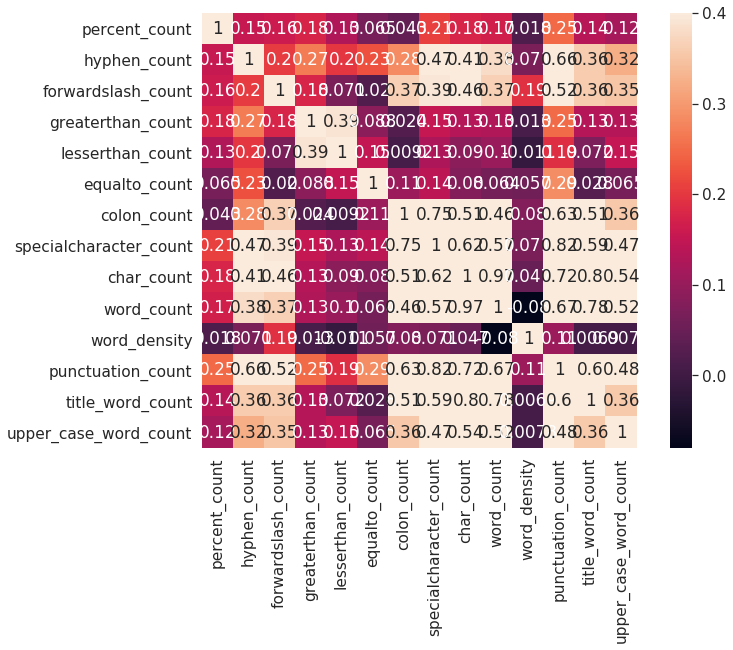

In [200]:
#correlation matrix
corrmat = data_features.corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corrmat, vmax=.4, annot=True,square=True);

#### Try adding scaling then modeling

In [244]:
Xarray = data_features.values
Yarray = data_target.values
print(Xarray)
#Yarray
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(Xarray)
print(X_train_minmax)

[[  6.   5.   0. ... 163. 190.  61.]
 [ 71.   0.  17. ... 214.   7.   5.]
 [ 25.  24.   2. ... 161. 102.  26.]
 ...
 [ 34.  20.   5. ... 207.  39. 201.]
 [  8.   7.   0. ... 109.  75.  21.]
 [  2.   2.   0. ...  74.  52.  12.]]
[[0.00639659 0.0177305  0.         ... 0.03223255 0.34926471 0.04426705]
 [0.07569296 0.         0.04450262 ... 0.04231758 0.01286765 0.00362845]
 [0.02665245 0.08510638 0.0052356  ... 0.03183706 0.1875     0.01886792]
 ...
 [0.03624733 0.07092199 0.01308901 ... 0.04093336 0.07169118 0.14586357]
 [0.00852878 0.0248227  0.         ... 0.02155428 0.13786765 0.01523948]
 [0.0021322  0.0070922  0.         ... 0.01463318 0.09558824 0.00870827]]


In [247]:
Xtestarray = datatest_features.values
Ytestarray = datatest_target.values
print(Xtestarray)
#Yarray
#from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()
X_test_minmax = min_max_scaler.fit_transform(Xtestarray)
print(X_test_minmax)

[[  3.   4.   0. ...  16.   8.   8.]
 [  1.  18.   1. ...  65. 150.  30.]
 [  4.   6.   0. ...  82.  47.  45.]
 ...
 [  4.  13.   4. ...  68.  27.  19.]
 [  3.   3.   0. ...  57.  28.  23.]
 [  2.   8.   0. ...  34.  19.  11.]]
[[0.00345224 0.01393728 0.         ... 0.00469897 0.01426025 0.01125176]
 [0.00115075 0.06271777 0.00234192 ... 0.01908957 0.26737968 0.04219409]
 [0.00460299 0.02090592 0.         ... 0.02408223 0.08377897 0.06329114]
 ...
 [0.00460299 0.04529617 0.00936768 ... 0.01997063 0.04812834 0.02672293]
 [0.00345224 0.01045296 0.         ... 0.01674009 0.04991087 0.0323488 ]
 [0.0023015  0.02787456 0.         ... 0.00998532 0.03386809 0.01547117]]


In [248]:
validation_size = 0.25
seed = 17
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X_train_minmax, Yarray, test_size=validation_size, random_state=seed)
# 
# using Logistric regression
LRmodels=LogisticRegression(solver='liblinear')
LRmodels.fit(X_train,Y_train)
predictions = LRmodels.predict(X_validation)
from sklearn.metrics import classification_report
print(classification_report(Y_validation,predictions))

              precision    recall  f1-score   support

           0       0.56      0.78      0.65     11711
           1       0.57      0.32      0.41     10534

   micro avg       0.57      0.57      0.57     22245
   macro avg       0.57      0.55      0.53     22245
weighted avg       0.57      0.57      0.54     22245



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [208]:
print(LRmodels.coef_)

[[-1.40979106  4.70387502 -0.06176675  1.54837102  1.59401176  0.67072869
  -0.21580884 -0.06027959 -2.38246433 -1.09494474 -4.44710297  1.75327049
   0.08410689  3.43336982]]


In [249]:
# using decision tree
DTmodels=DecisionTreeClassifier()
DTmodels.fit(X_train,Y_train)
predictions = DTmodels.predict(X_validation)
#from sklearn.metrics import classification_report
print(classification_report(Y_validation,predictions))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59     11711
           1       0.54      0.54      0.54     10534

   micro avg       0.57      0.57      0.57     22245
   macro avg       0.57      0.57      0.57     22245
weighted avg       0.57      0.57      0.57     22245



In [250]:
predictionstest = DTmodels.predict(X_test_minmax)
print(classification_report(Ytestarray,predictionstest))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54     19848
           1       0.50      0.50      0.50     18283

   micro avg       0.52      0.52      0.52     38131
   macro avg       0.52      0.52      0.52     38131
weighted avg       0.52      0.52      0.52     38131



In [210]:
feat_importance = DTmodels.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))

feat importance = [0.01045122 0.03029887 0.03902959 0.00670654 0.00365505 0.01035593
 0.04210505 0.04324441 0.05750869 0.03884818 0.06019741 0.0469223
 0.04990416 0.04669896]


In [212]:
# using CV 
validation_size = 0.25
seed = 17
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X_train_minmax, Yarray, test_size=validation_size, random_state=seed)
# 
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

LR: 0.562639 (0.006742)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

LDA: 0.562618 (0.005733)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when

KNN: 0.600437 (0.004259)
CART: 0.575246 (0.006512)
NB: 0.548611 (0.009222)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVM: 0.525542 (0.006002)


In [213]:
clf = DecisionTreeClassifier(random_state=0)

In [214]:
cross_val_score(clf, data_features, data_target, cv=10)

array([0.54551241, 0.531986  , 0.57431572, 0.54393505, 0.52929004,
       0.53263292, 0.55205349, 0.55428208, 0.53804521, 0.56956383])

In [77]:
array = data_features.values
array2 = data_target.values
X = array[:,:]
Y = array2[:,:]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
clf.fit(X_train, Y_train)

feat_importance = clf.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))

feat importance = [0.00615505 0.04212473 0.04254591 0.00397417 0.00593372 0.00691182
 0.04195768 0.04635072 0.06509914 0.07709324 0.05233269 0.05569768
 0.04851189]


In [170]:
list_features = ['percent_count', 'hyphen_count', 'forwardslash_count',
       'greaterthan_count', 'lesserthan_count', 'equalto_count', 'colon_count',
       'specialcharacter_count', 'word_count ','word_density',
       'punctuation_count', 'title_word_count', 'upper_case_word_count' ]

#sorted_features.reverse()
#sorted(feat_importance,reverse=True)
#feat_importance.reverse()
#print(sorted_features)
#for ind,i in enumerate(list_features):
#    print(i)
#    print(feat_importance[ind])

# Sort the features in terms of feature importance
print('Feature sorted by importance in descending')
sorted_features = [x for _,x in sorted(zip(feat_importance,list_features),reverse=True)]
sorted_importance = sorted(feat_importance, reverse=True)
for ind,i in enumerate(sorted_features):
    print(i)
    print(sorted_importance[ind])

Feature sorted by importance in descending
upper_case_word_count
0.07709324249939518
title_word_count
0.06509914141779735
punctuation_count
0.05569768335007969
word_density
0.05233269266204402
word_count 
0.04851189141549765
specialcharacter_count
0.0463507187622478
colon_count
0.042545911346620904
equalto_count
0.04212473216799961
lesserthan_count
0.04195768245573615
greaterthan_count
0.006911824209708732
forwardslash_count
0.006155052780578583
hyphen_count
0.005933723694506127
percent_count
0.003974173637682369


In [79]:
# Make predictions on validation dataset
predictions = clf.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.5792163543441227
[[1171  906]
 [ 823 1209]]
              precision    recall  f1-score   support

           0       0.59      0.56      0.58      2077
           1       0.57      0.59      0.58      2032

   micro avg       0.58      0.58      0.58      4109
   macro avg       0.58      0.58      0.58      4109
weighted avg       0.58      0.58      0.58      4109



### Using countvector for classification

In [20]:
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [21]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data['pagetext'], data['flag'],random_state=12, test_size=0.33)

In [22]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [23]:
test_y=encoder.fit_transform(datatest['flag'])
test_x=datatest['pagetext']

... Processing


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[0.8764217  0.1235783 ]
 [0.66701029 0.33298971]
 [0.35671998 0.64328002]
 ...
 [0.03306585 0.96693415]
 [0.08112981 0.91887019]
 [0.4400096  0.5599904 ]]
Test accuracy is 0.7954297779594061
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     15314
           1       0.78      0.79      0.79     14050

   micro avg       0.80      0.80      0.80     29364
   macro avg       0.80      0.80      0.80     29364
weighted avg       0.80      0.80      0.80     29364



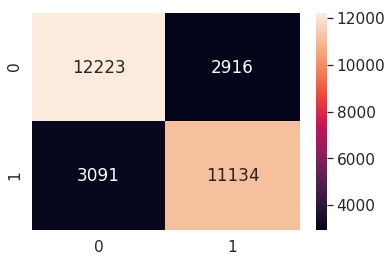

In [254]:
# LR model with  countV
model_pipeline = Pipeline([
              #  ('tfidf',CountVectorizer(token_pattern=r'\w{3,}', stop_words='english')),
                ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english')),
   # ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english',min_df=5)),
  #   ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{11,}',ngram_range=(1,11), stop_words='english',min_df=5)),
  #   ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,11), stop_words='english',min_df=5)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
                #('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
                #('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])
                #('clf',ensemble.RandomForestClassifier()),])
    
print('... Processing')
model_pipeline.fit(train_x,train_y)

#prediction = model_pipeline.predict(valid_x)
#print(prediction)

pred = model_pipeline.predict_proba(valid_x)
print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
conf_mat = confusion_matrix(valid_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, valid_y))

[[0.57071227 0.42928773]
 [0.97560422 0.02439578]
 [0.88109612 0.11890388]
 ...
 [0.24933417 0.75066583]
 [0.7031108  0.2968892 ]
 [0.3050615  0.6949385 ]]
Test accuracy is 0.7906952348482862
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     20065
           1       0.78      0.79      0.78     18066

   micro avg       0.79      0.79      0.79     38131
   macro avg       0.79      0.79      0.79     38131
weighted avg       0.79      0.79      0.79     38131



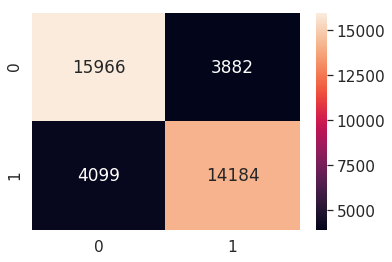

In [255]:
pred = model_pipeline.predict_proba(test_x)
print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(test_y, prediction)))
conf_mat = confusion_matrix(test_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, test_y))

In [ ]:
# LR model with n gram and tfidf
model_pipeline = Pipeline([
              #  ('tfidf',CountVectorizer(token_pattern=r'\w{3,}', stop_words='english')),
              #  ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,3), stop_words='english')),
   # ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english',min_df=5)),
    ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,3), stop_words='english',min_df=5)),
  #   ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,11), stop_words='english',min_df=5)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
                #('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
                #('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])
                #('clf',ensemble.RandomForestClassifier()),])
    
print('... Processing')
model_pipeline.fit(train_x,train_y)

#prediction = model_pipeline.predict(valid_x)
#print(prediction)

pred = model_pipeline.predict_proba(valid_x)
print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
conf_mat = confusion_matrix(valid_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, valid_y))

... Processing


In [ ]:
pred = model_pipeline.predict_proba(test_x)
print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(test_y, prediction)))
conf_mat = confusion_matrix(test_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, test_y))

... Processing


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[0.21228567 0.78771433]
 [0.1228365  0.8771635 ]
 [0.16507202 0.83492798]
 ...
 [0.4902643  0.5097357 ]
 [0.62316968 0.37683032]
 [0.38303133 0.61696867]]
Test accuracy is 0.8324819506879172
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     14980
           1       0.84      0.82      0.83     14384

   micro avg       0.83      0.83      0.83     29364
   macro avg       0.83      0.83      0.83     29364
weighted avg       0.83      0.83      0.83     29364



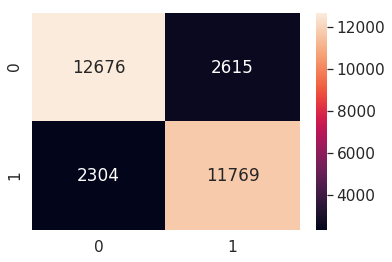

In [24]:
# LR model with n gram and countvectorizer
model_pipeline = Pipeline([
              #  ('tfidf',CountVectorizer(token_pattern=r'\w{3,}', stop_words='english')),
                ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,3), stop_words='english')),
   # ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english',min_df=5)),
   #  ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,3), stop_words='english',min_df=5)),
  #   ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,11), stop_words='english',min_df=5)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
                #('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
                #('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])
                #('clf',ensemble.RandomForestClassifier()),])
    
print('... Processing')
model_pipeline.fit(train_x,train_y)

#prediction = model_pipeline.predict(valid_x)
#print(prediction)

pred = model_pipeline.predict_proba(valid_x)
print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
conf_mat = confusion_matrix(valid_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, valid_y))

[[0.02238888 0.97761112]
 [0.45110501 0.54889499]
 [0.7051436  0.2948564 ]
 ...
 [0.46315472 0.53684528]
 [0.76114426 0.23885574]
 [0.4194759  0.5805241 ]]
Test accuracy is 0.8294563478534526
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     19622
           1       0.83      0.82      0.82     18509

   micro avg       0.83      0.83      0.83     38131
   macro avg       0.83      0.83      0.83     38131
weighted avg       0.83      0.83      0.83     38131



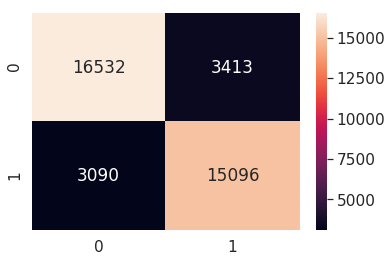

In [25]:
pred = model_pipeline.predict_proba(test_x)
print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(test_y, prediction)))
conf_mat = confusion_matrix(test_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, test_y))

In [26]:
joblib.dump(model_pipeline, '../picklefolder_ngrams/notdoctornote_pagelevelmodel_LR_April1719.pickle') 

['../picklefolder_ngrams/notdoctornote_pagelevelmodel_LR_April1719.pickle']

... Processing


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0 0 1 ... 1 1 1]
Test accuracy is 0.741043454570222
              precision    recall  f1-score   support

           0       0.83      0.71      0.77     17637
           1       0.64      0.78      0.71     11727

   micro avg       0.74      0.74      0.74     29364
   macro avg       0.74      0.75      0.74     29364
weighted avg       0.76      0.74      0.74     29364



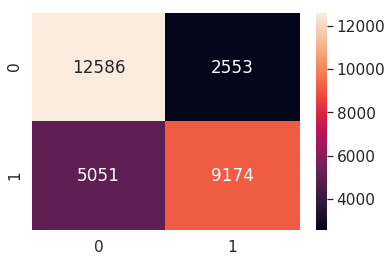

In [258]:
# RF method
model_pipeline = Pipeline([
                #('tfidf',CountVectorizer(token_pattern=r'\w{3,}', stop_words='english')),
                ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english')),
    #('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english',min_df=5)),
    #('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,11), stop_words='english',min_df=5)),
    
                #('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
                #('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
                #('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])
                ('clf',ensemble.RandomForestClassifier()),])
            
             
print('... Processing')
model_pipeline.fit(train_x,train_y)
#joblib.dump(model_pipeline, './picklefolder_ngrams/PhraseReason_cholestrol.pickle') 
#print("---pickle file dumped")
prediction = model_pipeline.predict(valid_x)
print(prediction)
'''
pred = model_pipeline.predict_proba(valid_x)
print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.1, 1, 0)
print(prediction)
'''
print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
conf_mat = confusion_matrix(valid_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, valid_y))

[[1.  0. ]
 [0.6 0.4]
 [0.8 0.2]
 ...
 [0.2 0.8]
 [0.7 0.3]
 [0.4 0.6]]
Test accuracy is 0.7341270881959561
              precision    recall  f1-score   support

           0       0.83      0.71      0.76     23134
           1       0.63      0.77      0.70     14997

   micro avg       0.73      0.73      0.73     38131
   macro avg       0.73      0.74      0.73     38131
weighted avg       0.75      0.73      0.74     38131



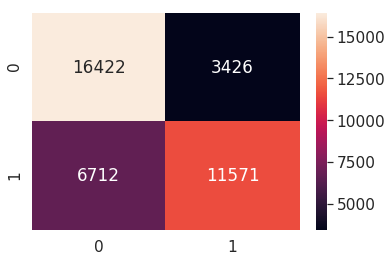

In [259]:
pred = model_pipeline.predict_proba(test_x)
print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(test_y, prediction)))
conf_mat = confusion_matrix(test_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, test_y))